In [1]:
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
import importlib as imp
import json

import data_loader.data_loader as data_loader
from trainer.trainer import Trainer
from model.model import TorchModel
from utils import utils
import model.loss as module_loss
import model.metric as module_metric
import warnings

warnings.filterwarnings("ignore")
torch.set_warn_always(False)

# TODO: move to new project
# TODO: make data class for lats and lons

# https://github.com/victoresque/pytorch-template/tree/master

In [2]:
EXP_NAME = "test"

with open("config/config_" + EXP_NAME + ".json") as f:
    config = json.load(f)
    assert config["name"] == "exp_" + EXP_NAME
config

{'name': 'exp_test',
 'device': 'gpu',
 'data_loader': {'data_dir': 'data/', 'batch_size': 32, 'args': {}},
 'arch': {'type': 'test', 'args': {}},
 'optimizer': {'type': 'Adam',
  'args': {'lr': 1e-05, 'weight_decay': 0, 'amsgrad': False}},
 'criterion': 'ShashNLL',
 'metrics': ['custom_mae', 'iqr_capture', 'sign_test'],
 'trainer': {'max_epochs': 15,
  'save_dir': 'saved_models/',
  'early_stopping': {'args': {'patience': 2, 'min_delta': 0.0}}}}

In [3]:
SEED = 44
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True


trainset = data_loader.CustomData(
    config["data_loader"]["data_dir"] + "train_data.pickle"
)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "val_data.pickle")
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

model = TorchModel(target=trainset.target)
model.freeze_layers(freeze_id="tau")
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    trainable_params, **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

torchinfo.summary(
    model,
    [
        trainset.input[: config["data_loader"]["batch_size"]].shape,
        trainset.input_unit[: config["data_loader"]["batch_size"]].shape,
    ],
    verbose=0,
)

Layer (type:depth-idx)                   Output Shape              Param #
TorchModel                               [32, 4]                   --
├─CircularPad2d: 1-1                     [32, 1, 72, 154]          --
├─Sequential: 1-2                        [32, 5760]                --
│    └─Sequential: 2-1                   [32, 32, 36, 77]          --
│    │    └─Conv2d: 3-1                  [32, 32, 72, 154]         832
│    │    └─ReLU: 3-2                    [32, 32, 72, 154]         --
│    │    └─MaxPool2d: 3-3               [32, 32, 36, 77]          --
│    └─Sequential: 2-2                   [32, 32, 18, 39]          --
│    │    └─Conv2d: 3-4                  [32, 32, 36, 77]          9,248
│    │    └─ReLU: 3-5                    [32, 32, 36, 77]          --
│    │    └─MaxPool2d: 3-6               [32, 32, 18, 39]          --
│    └─Sequential: 2-3                   [32, 32, 9, 20]           --
│    │    └─Conv2d: 3-7                  [32, 32, 18, 39]          9,248
│    │  

In [4]:
model = model.to(device)
trainer.fit()

Epoch   0/15
  11.8s - train_loss: 1.10351 - val_loss: 0.95180
Epoch   1/15
  11.0s - train_loss: 0.82079 - val_loss: 0.69008
Epoch   2/15
  11.6s - train_loss: 0.63215 - val_loss: 0.54606
Epoch   3/15
  10.9s - train_loss: 0.52397 - val_loss: 0.44674
Epoch   4/15
  11.3s - train_loss: 0.44095 - val_loss: 0.37889
Epoch   5/15
  11.1s - train_loss: 0.39392 - val_loss: 0.33956
Epoch   6/15
  11.6s - train_loss: 0.36261 - val_loss: 0.30949
Epoch   7/15
  11.4s - train_loss: 0.33073 - val_loss: 0.27853
Epoch   8/15
  11.4s - train_loss: 0.29300 - val_loss: 0.24329
Epoch   9/15
  11.2s - train_loss: 0.24625 - val_loss: 0.21153
Epoch  10/15
  11.0s - train_loss: 0.22386 - val_loss: 0.19473
Epoch  11/15
  11.0s - train_loss: 0.20292 - val_loss: 0.19700
Epoch  12/15
  11.3s - train_loss: 0.18795 - val_loss: 0.16672
Epoch  13/15
  11.0s - train_loss: 0.17337 - val_loss: 0.17272
Epoch  14/15
  11.5s - train_loss: 0.15952 - val_loss: 0.15157
Epoch  15/15
  11.2s - train_loss: 0.14950 - val_loss: 

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


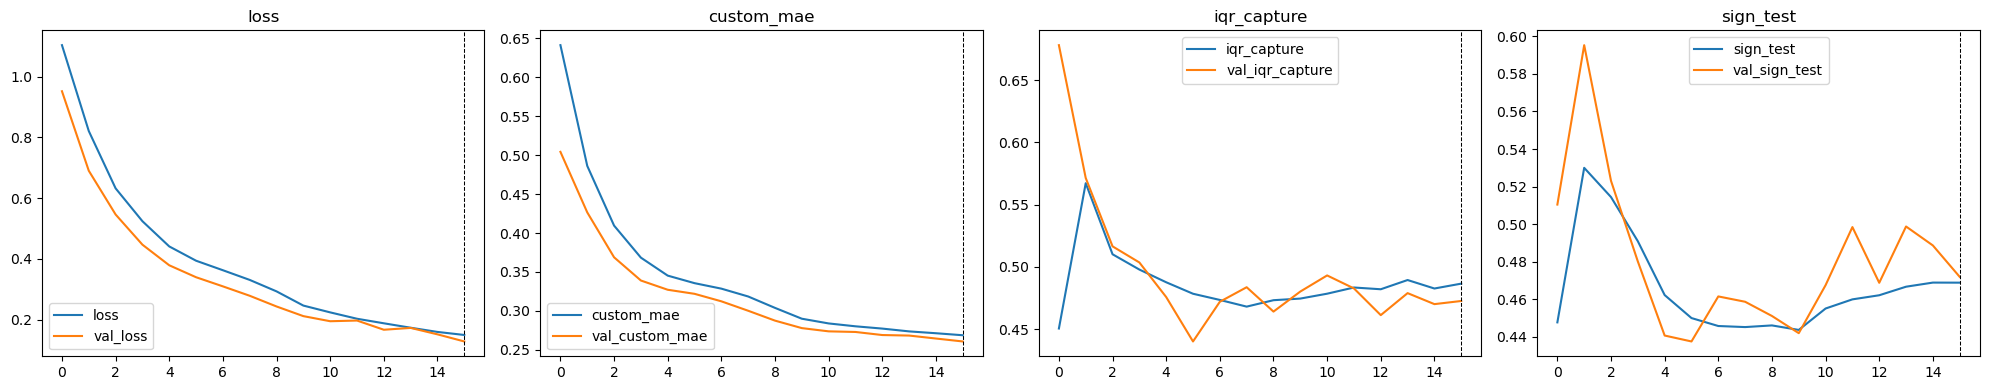

In [5]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
        x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

In [6]:
input = torch.Tensor(valset.input[:3]).to(device)
input_unit = torch.Tensor(valset.input_unit[:3]).to(device)
with torch.no_grad():
    pred = model(input, input_unit)
pred = pred.cpu().numpy()
pred

array([[2.0077906 , 0.49405584, 0.4003027 , 1.        ],
       [1.9630917 , 0.34740618, 0.38316488, 1.        ],
       [1.9982221 , 0.37892237, 0.40071222, 1.        ]], dtype=float32)

tensor([2.2832, 2.1480, 2.2096])
tensor([0.2926, 0.1426, 0.1722])
tensor([2.2109, 2.0995, 2.1542])


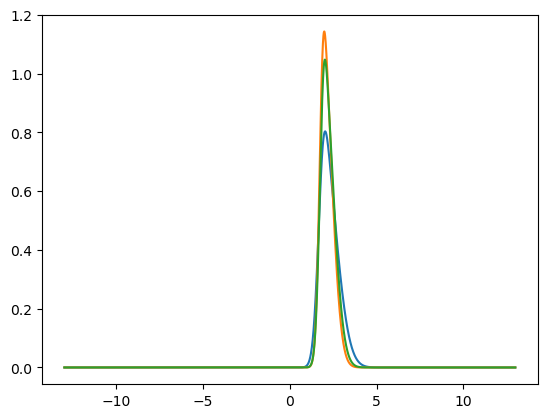

In [14]:
import shash.shash_torch
from shash.shash_torch import Shash
imp.reload(shash.shash_torch)

sample = 1
x = np.arange(-13, 13, 0.01)
dist = Shash(
    mu=torch.tensor(pred[:, 0]),
    sigma=torch.tensor(pred[:, 1]),
    gamma=torch.tensor(pred[:, 2]),
    tau=torch.tensor(pred[:, 3]),
)
p = dist.prob(torch.tensor(x[:,None]))
plt.plot(x, p)

print(dist.mean())
print(dist.var())
print(dist.median())

In [8]:
# import shash.shash_torch
# from shash.shash_torch import Shash
# imp.reload(shash.shash_torch)